In [ ]:
pip install alpha_vantage

In [ ]:
pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.6 MB/s eta 0:00:00


### Step 2: Import Libraries

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from alpha_vantage.timeseries import TimeSeries
import mplfinance as mpf
from datetime import datetime, timedelta
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


### Step 3: Fetch Stock Data

In [ ]:
# Put Alpha Vantage API key
API_KEY = 'cmufi69r01qggkbpuplgcmufi69r01qggkbpupm0'

# Create an Alpha Vantage TimeSeries object with our API key
ts = TimeSeries(key=API_KEY, output_format='pandas')

# List of stock symbols
symbols = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'TSLA', 'NVDA']

# Dictionary to store data for each stock
stock_data = {}

In [ ]:
# Calculate the start and end dates for one year of historical daily data
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')

# Loop through each stock symbol and fetch historical daily data
for symbol in symbols:
    try:
        # Get historical daily data for each stock
        data, meta_data = ts.get_daily(symbol=symbol, outputsize='full')

        # Filter data for the desired date range
        data = data.loc[start_date:end_date]

        # Store the data in the dictionary
        stock_data[symbol] = data
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

# Print the data for each stock
for symbol, data in stock_data.items():
    print(f"\n{symbol} Historical Daily Data:\n{data}")


AAPL Historical Daily Data:
            1. open  2. high   3. low  4. close    5. volume
date                                                        
2024-02-01  183.985  186.950  183.820    186.86   64885408.0
2024-01-31  187.040  187.095  184.350    184.40   55467803.0
2024-01-30  190.940  191.800  187.470    188.04   55859370.0
2024-01-29  192.010  192.200  189.580    191.73   47145622.0
2024-01-26  194.270  194.760  191.940    192.42   44594011.0
...             ...      ...      ...       ...          ...
2023-02-08  153.880  154.580  151.168    151.92   64120079.0
2023-02-07  150.640  155.230  150.640    154.65   83322551.0
2023-02-06  152.575  153.100  150.780    151.73   69858306.0
2023-02-03  148.030  157.380  147.830    154.50  154357337.0
2023-02-02  148.900  151.180  148.170    150.82  118338980.0

[251 rows x 5 columns]

GOOG Historical Daily Data:
            1. open  2. high    3. low  4. close   5. volume
date                                                        
202

Reviewing the content of our data, we can see that the data is numeric and the date is the index of the data. Notice also that weekends are missing from the records.

Quick note: Using globals() is a sloppy way of setting the DataFrame names, but it's simple. Now we have our data, let's perform some basic data analysis and check our data.

### Descriptive Statistics about the Data
.describe() generates descriptive statistics. Descriptive statistics include those that summarize the central tendency, dispersion, and shape of a dataset’s distribution, excluding NaN values.

Analyzes both numeric and object series, as well as DataFrame column sets of mixed data types. The output will vary depending on what is provided. Refer to the notes below for more detail.

In [ ]:
# Access and print the historical daily data for Tesla ('TSLA')
MSFT_data = stock_data['MSFT']
MSFT_data.tail(5)

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2023-02-08,273.200,276.760,266.21,266.73,54686049.0
2023-02-07,260.530,268.775,260.08,267.56,50841365.0
2023-02-06,257.440,258.300,254.78,256.77,22517997.0
2023-02-03,259.542,264.200,257.10,258.35,29077256.0
2023-02-02,258.820,264.690,257.25,264.60,39940437.0


In [ ]:
MSFT_data.describe()

,1. open,2. high,3. low,4. close,5. volume
count,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,326.777303,329.861003,323.849402,326.978506,2.700663e+07
std,39.186426,39.221581,39.047315,39.224317,1.024807e+07
min,246.550000,250.930000,245.610000,246.270000,1.017665e+07
25%,306.795000,309.055000,304.180000,306.280000,2.100454e+07
50%,330.960000,333.080000,326.940000,329.320000,2.435411e+07
75%,350.475000,355.965000,345.220000,351.890000,2.902033e+07
max,412.260000,415.320000,406.450100,409.720000,7.850232e+07


### Information About the Data
.info() method prints information about a DataFrame including the index dtype and columns, non-null values, and memory usage.

In [ ]:
# General info
MSFT_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2024-02-01 to 2023-02-02
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   1. open    251 non-null    float64
 1   2. high    251 non-null    float64
 2   3. low     251 non-null    float64
 3   4. close   251 non-null    float64
 4   5. volume  251 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB


We have only **251** records in one year because weekends are not included in the data.

### Time Series Visualization

### Closing Price
The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time.

**Trend In The Dataset**

We can see the change in trend in our dataset, Trend helps us see where the value of data that we are considering is going upward or downward in the long run.

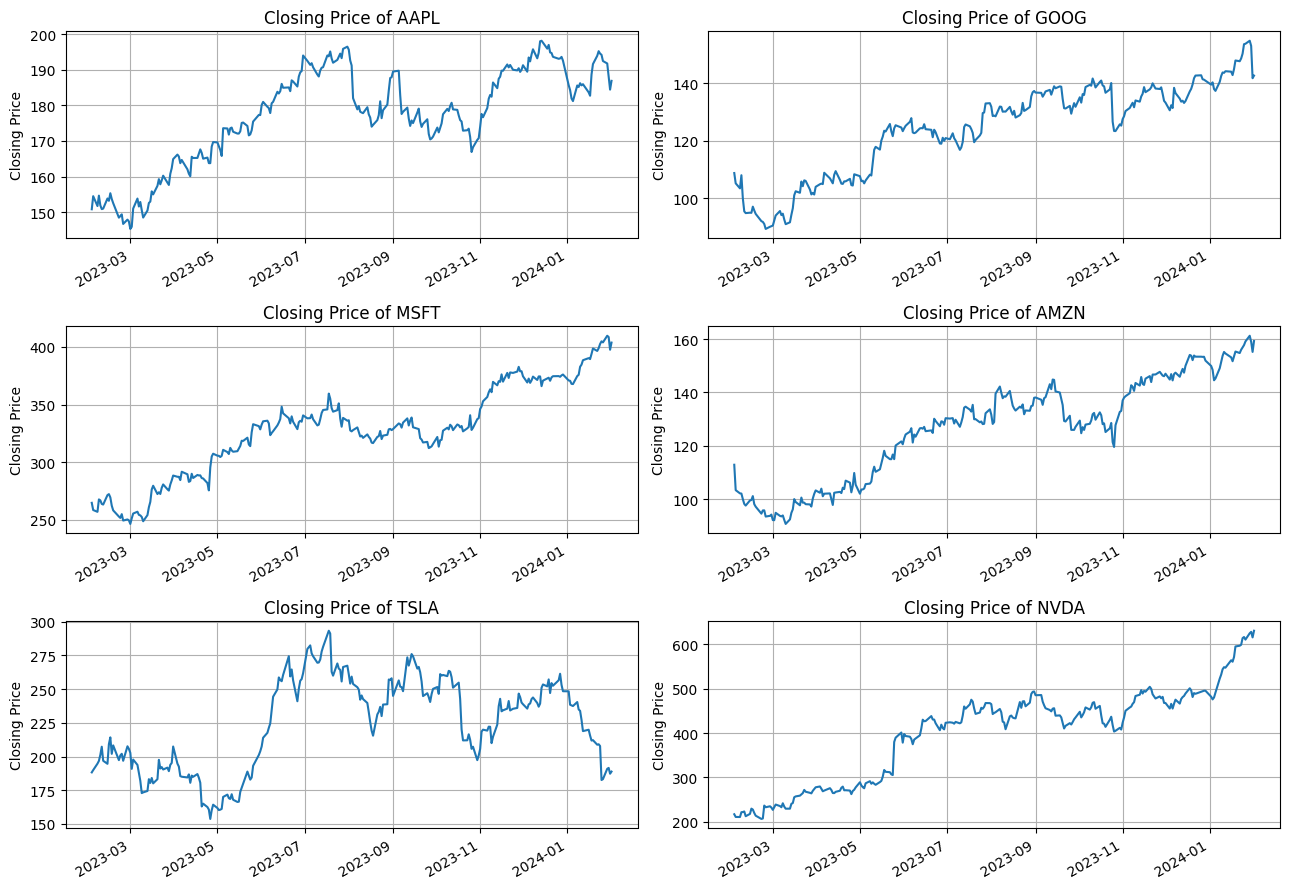

In [ ]:
# Let's see a historical view of the closing price
plt.figure(figsize=(13, 9))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, symbol in enumerate(symbols, 1):
    plt.subplot(3, 2, i)  # Adjust the subplot grid based on the number of stocks
    stock_data[symbol]['4. close'].plot(grid=True)  # Assuming '4. close' is the closing price column
    plt.ylabel('Closing Price')
    plt.xlabel(None)
    plt.title(f"Closing Price of {symbol}")

plt.tight_layout()
plt.show()

why weekly charts? 🤔

The choice between weekly and daily charts is determined by your trading style and goals. Weekly charts provide a more broad view of price trends, making them appropriate for long-term traders and institutiional analysts. Combining weekly and daily charts can confirm trends and signals while also providing a thorough analysis. Weekly charts suit less active traders looking for long-term trend changes or downtrend signals. Finally , the decision is based on your preferences and the level of detail required for successful trading.

## Candlestick Charts

Candlestick graphs/charts provide a visual representation of price fluctuations, aiding traders in pattern identification and predicting short-term price trends. Each candle, representing a time period, consists of a body, upper shadow, and lower shadow.

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=MSFT_data.index,
                open=MSFT_data['1. open'],
                high=MSFT_data['2. high'],
                low=MSFT_data['3. low'],
                close=MSFT_data['4. close'])])

fig.update_layout(title='Microsoft Stock Price Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Stock Price (USD)')

fig.update_layout(template='plotly_dark')

fig.show()


### Volume of Sales
Volume is the amount of an asset or security that changes hands over some period of time, often over the course of a day. For instance, the stock trading volume would refer to the number of shares of security traded between its daily open and close. Trading volume, and changes to volume over the course of time, are important inputs for technical traders.

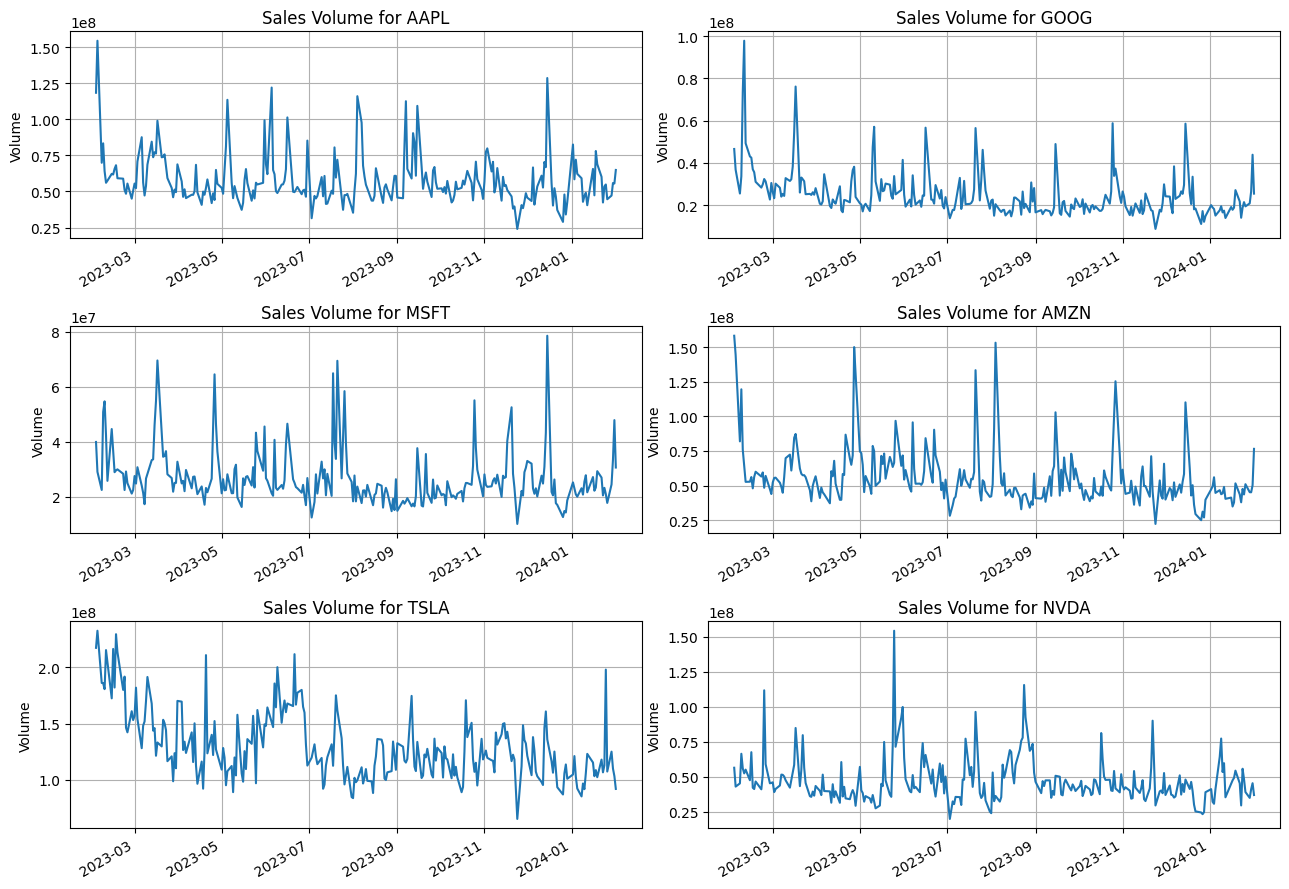

In [ ]:
# Let's see a historical view of the volume of sales
plt.figure(figsize=(13, 9))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, symbol in enumerate(symbols, 1):
    plt.subplot(3, 2, i)  # Adjust the subplot grid based on the number of stocks
    stock_data[symbol]['5. volume'].plot(grid=True)
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {symbol}")

plt.tight_layout()
plt.show()

Now that we've seen the visualizations for the closing price and the volume traded each day, let's go ahead and caculate the moving average for the stock.

### 2. Moving average of the various stocks
The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.

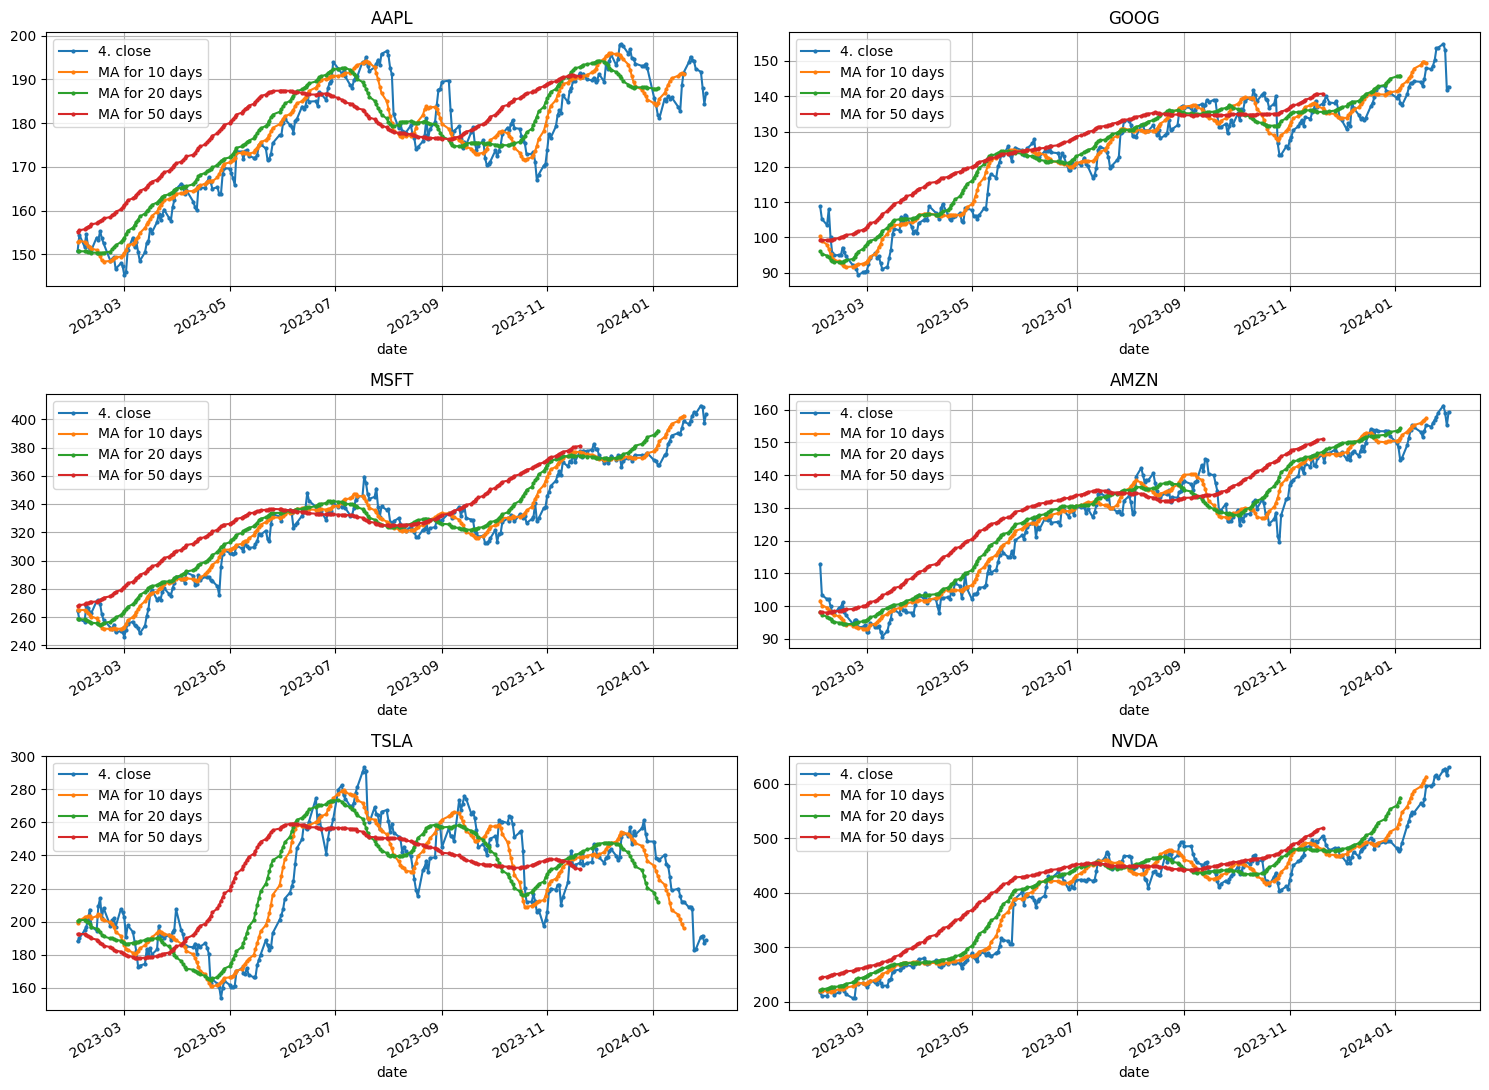

In [ ]:
# List of moving averages
ma_days = [10, 20, 50]

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 11))

# Loop through each stock symbol and plot moving averages
for i, symbol in enumerate(symbols):
    row = i // 2  # Row index for subplots
    col = i % 2   # Column index for subplots

    # Get the stock data for the current symbol
    stock_data_symbol = stock_data[symbol]

    # Calculate moving averages for the current symbol
    for ma in ma_days:
        column_name = f"MA for {ma} days"
        stock_data_symbol[column_name] = stock_data_symbol['4. close'].rolling(ma).mean()

    # Plot the data on the corresponding subplot with a square grid
    stock_data_symbol[['4. close', f'MA for {ma_days[0]} days', f'MA for {ma_days[1]} days', f'MA for {ma_days[2]} days']].plot(ax=axes[row, col], grid=True, linestyle='-', marker='o', markersize=2)
    axes[row, col].set_title(symbol)

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

We see in the graph that the best values to measure the moving average are 10 and 20 days because we still capture trends in the data without noise.

### Average daily stock return?
After conducting initial analysis, let's delve further into the examination. Our focus is now on assessing the stock's risk. To achieve this, we'll closely examine the daily fluctuations in the stock, emphasizing relative changes rather than absolute values. Let's utilize pandas to fetch the daily returns for All six stock.

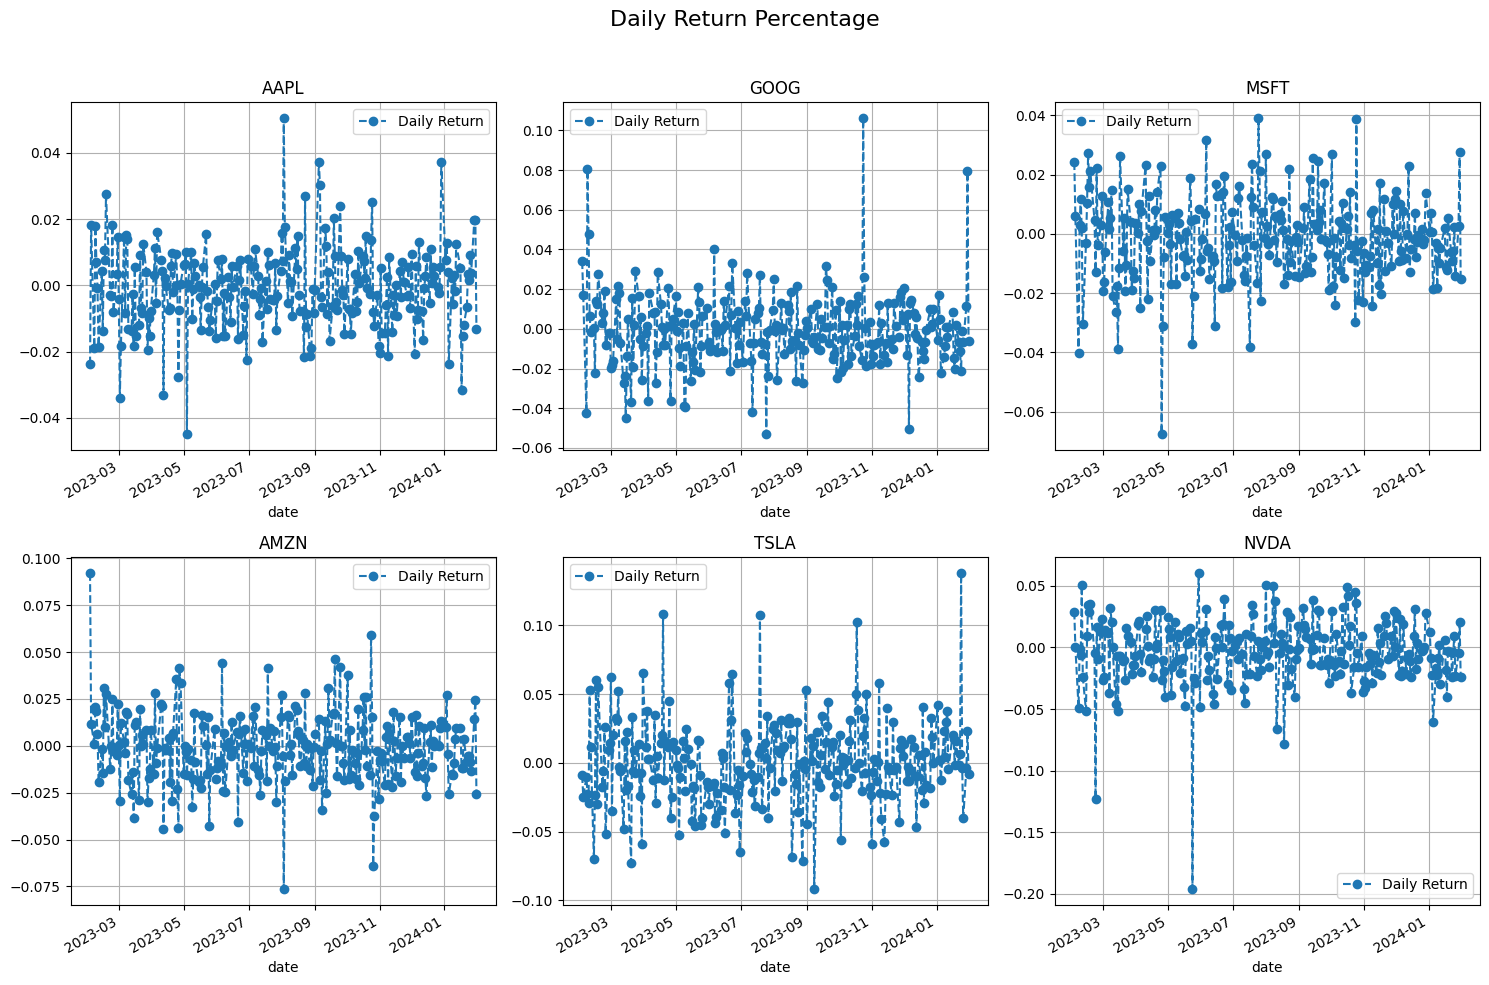

In [ ]:
# We'll use pct_change to find the percent change for each day
for symbol in symbols:
    stock_data[symbol]['Daily Return'] = stock_data[symbol]['4. close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Daily Return Percentage', fontsize=16)

for i, symbol in enumerate(symbols):
    row = i // 3  # Row index for subplots
    col = i % 3   # Column index for subplots

    stock_data[symbol]['Daily Return'].plot(ax=axes[row, col], legend=True, grid=True, linestyle='--', marker='o')
    axes[row, col].set_title(symbol)

fig.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout and add title
plt.show()


Great, now let's get an overall look at the average daily return using a histogram. We'll use seaborn to create both a histogram and kde plot on the same figure.

### Histogram of Daily Returns

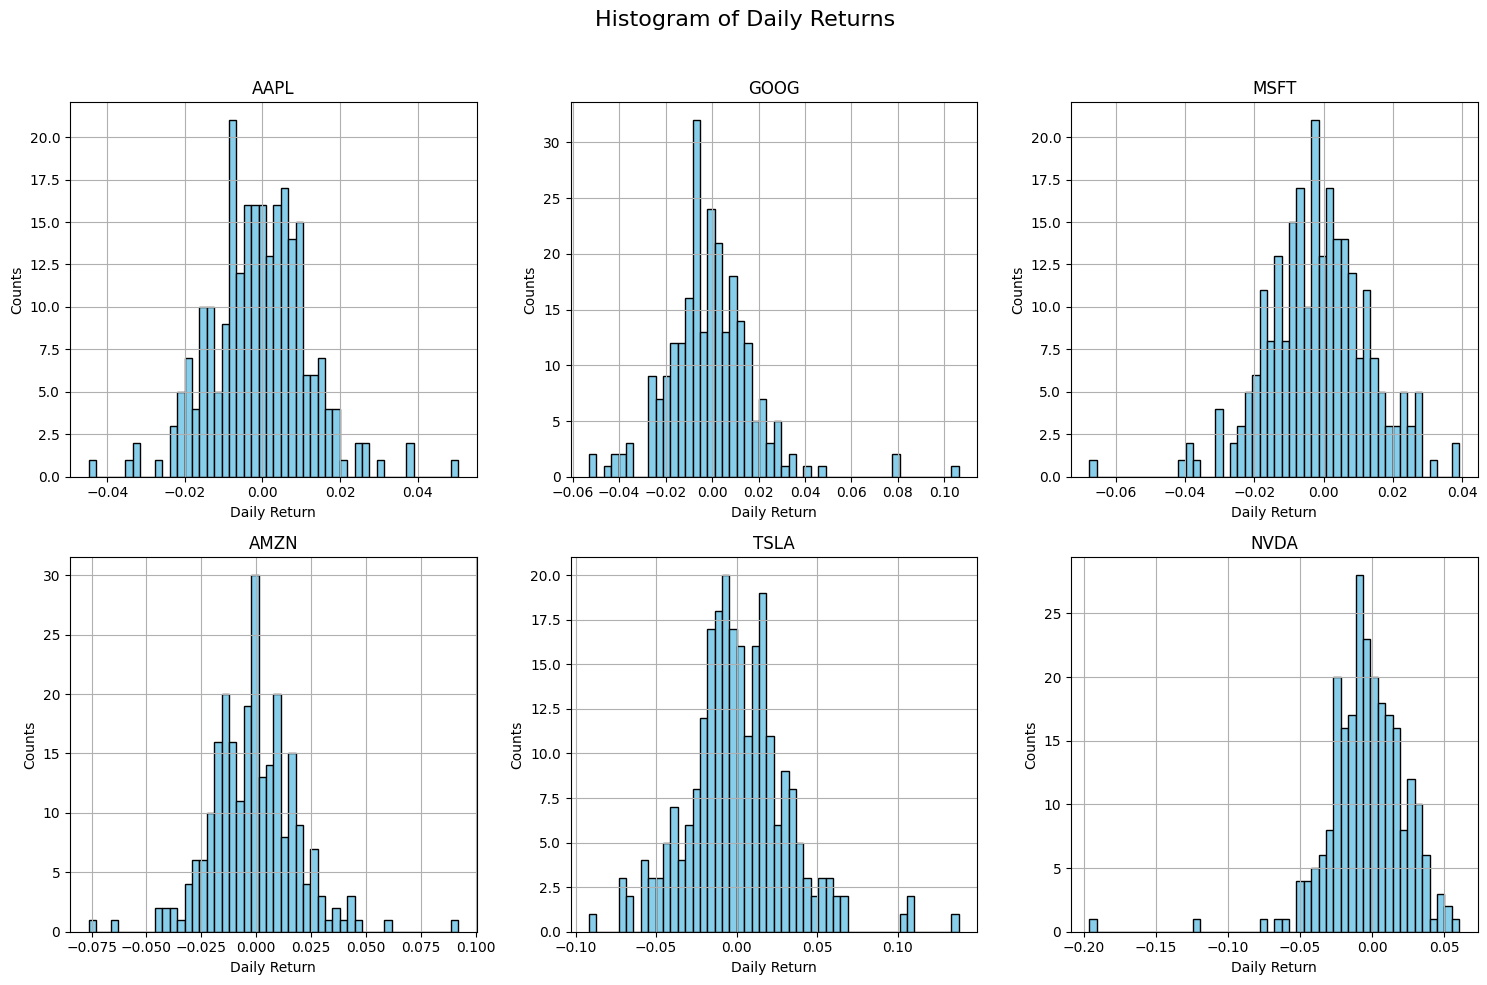

In [ ]:
plt.figure(figsize=(15, 10))
plt.suptitle('Histogram of Daily Returns', fontsize=16)

for i, symbol in enumerate(symbols, 1):
    plt.subplot(2, 3, i)
    stock_data[symbol]['Daily Return'].hist(bins=50, color='skyblue', edgecolor='black')
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{symbol}')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout and add title
plt.show()


## Correlation
- Correlation is a statistic that measures the degree to which two variables move in relation to each other which has a value that must fall between -1.0 and +1.0. Correlation measures association, but doesn’t show if x causes y or vice versa — or if the association is caused by a third factor[1].

- Now what if we wanted to analyze the returns of all the stocks in our list? Let's go ahead and build a DataFrame with all the ['Close'] columns for each of the stocks dataframes.

In [ ]:
# Define the start and end dates
start_date = datetime(2019, 1, 1)
end_date = datetime.now()

# Fetch historical data for the specified stock symbols
data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# Make a new returns DataFrame
returns_df = data.pct_change()
returns_df.head()


[*********************100%%**********************]  6 of 6 completed


Ticker,AAPL,AMZN,GOOG,MSFT,NVDA,TSLA
Date,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.099607,-0.025241,-0.028484,-0.036788,-0.060417,-0.031472
2019-01-04,0.042689,0.050064,0.053786,0.046509,0.064068,0.057697
2019-01-07,-0.002226,0.034353,-0.002167,0.001276,0.052941,0.054361
2019-01-08,0.019063,0.016612,0.007385,0.007251,-0.024895,0.001164


Now we can compare the daily percentage return of two stocks to check how correlated. First let's see a sotck compared to itself.

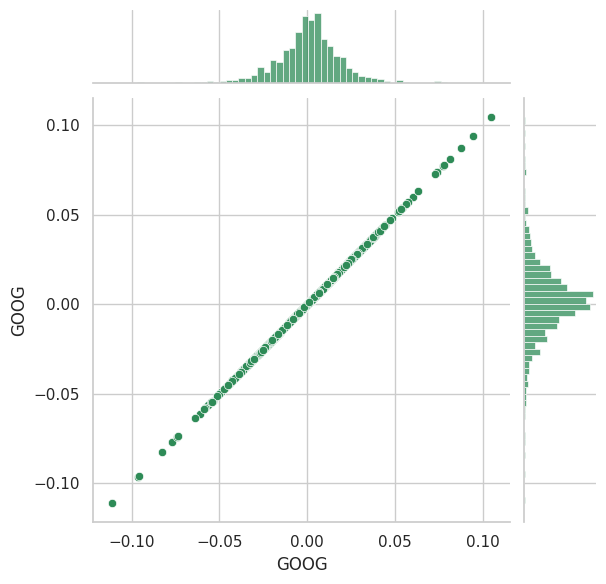

In [ ]:
# Assuming 'GOOG' is one of the symbols in your returns_df DataFrame
sns.set(style="whitegrid")  # Set seaborn style to include grid
g = sns.jointplot(x='GOOG', y='GOOG', data=returns_df, kind='scatter', color='seagreen')

# Add grid lines
g.ax_joint.grid(True)

plt.show()


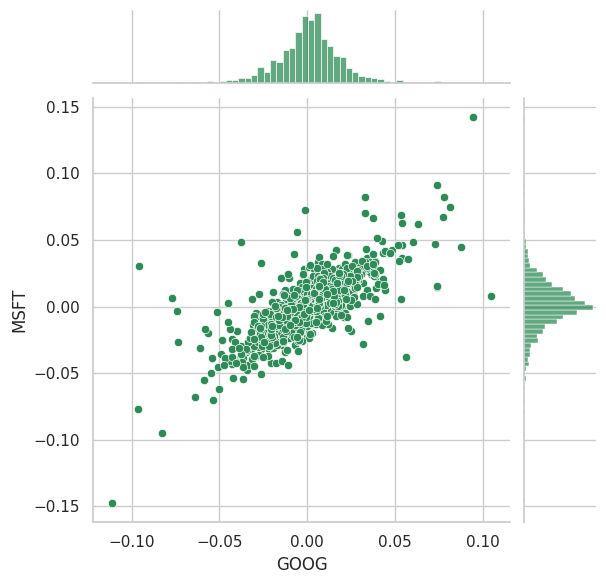

In [ ]:
g = sns.jointplot(x='GOOG', y='MSFT', data=returns_df, kind='scatter', color='seagreen')

# Add grid lines
g.ax_joint.grid(True)

plt.show()

So now we can see that if two stocks are perfectly (and positivley) correlated with each other a linear relationship bewteen its daily return values should occur.

Seaborn and pandas make it very easy to repeat this comparison analysis for every possible combination of stocks in our technology stock ticker list. We can use sns.pairplot() to automatically create this plot

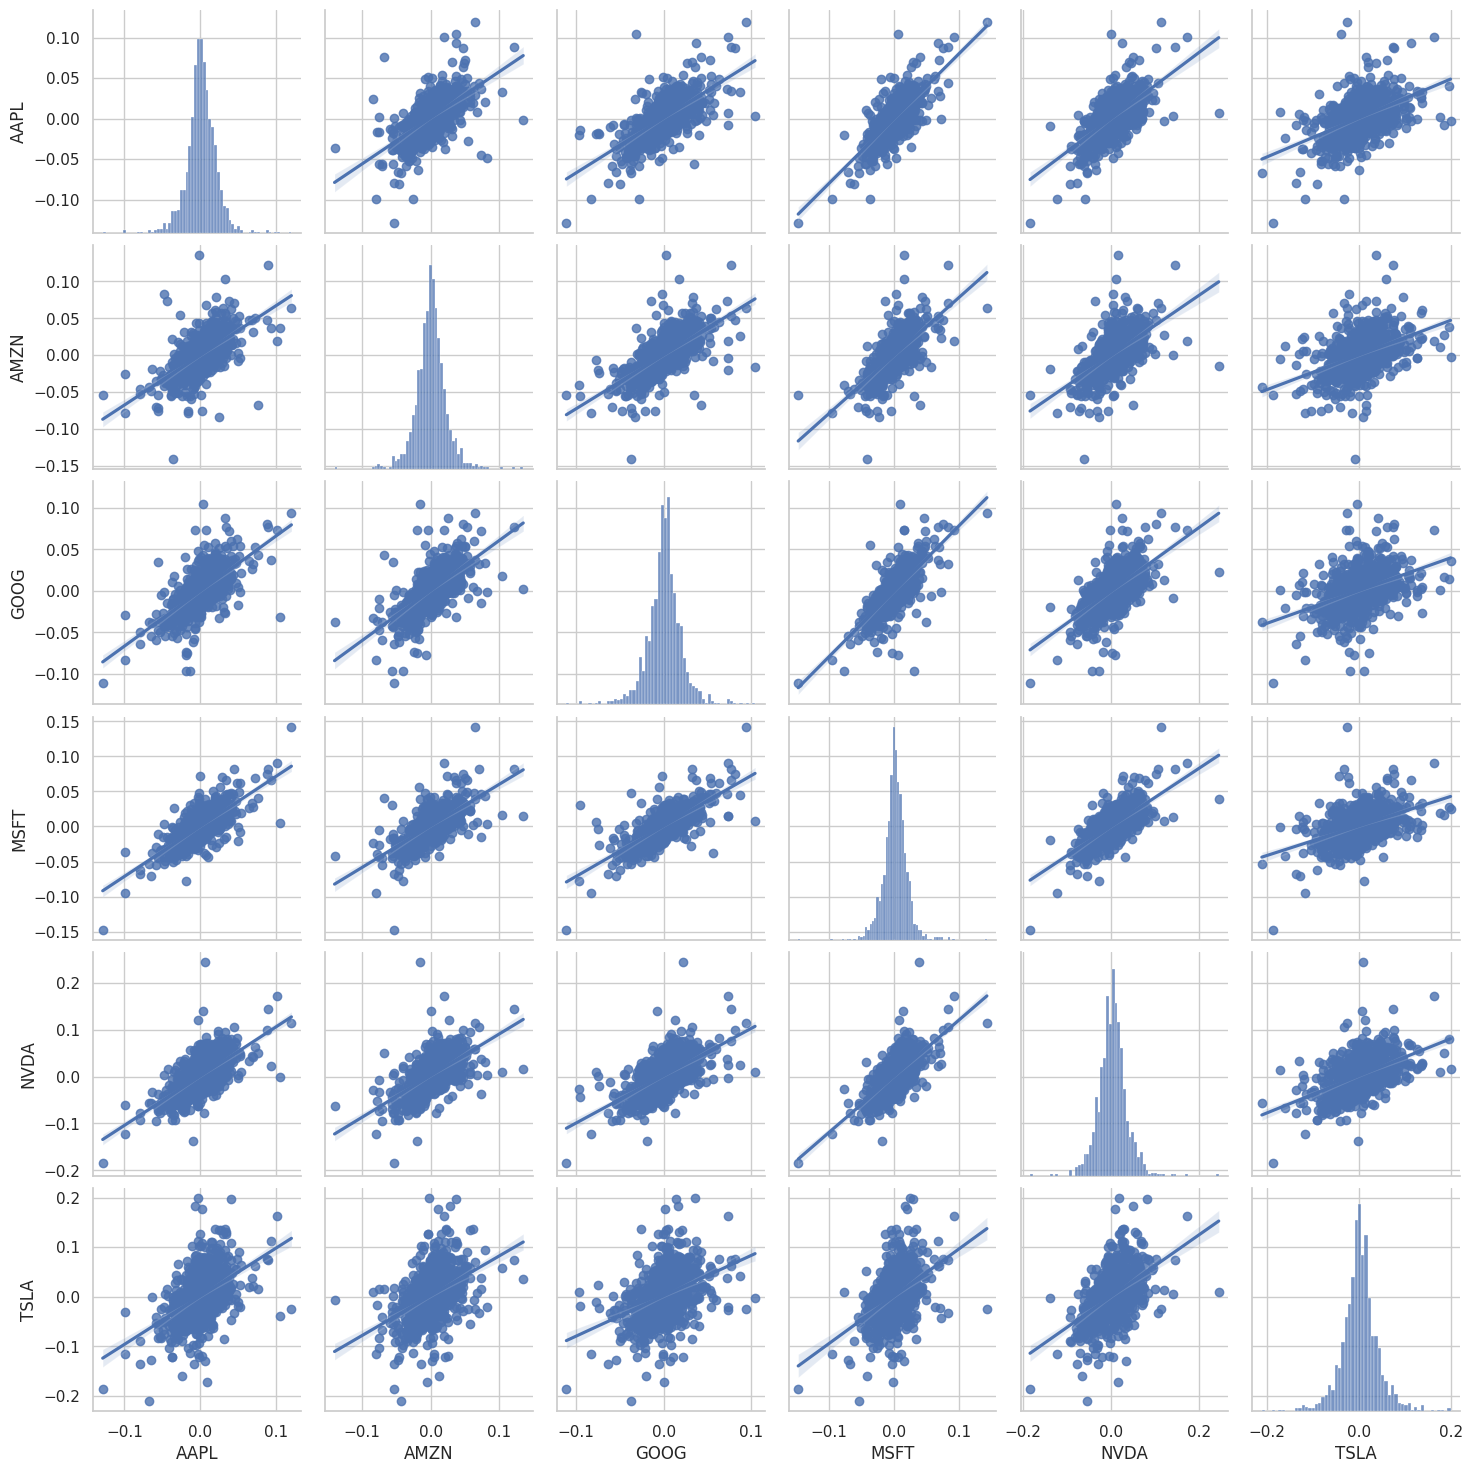

In [ ]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis
# of all the comparisons

sns.pairplot(returns_df, kind='reg')

Above we can see all the relationships on daily returns between all the stocks. A quick glance shows an interesting correlation between Google and Amazon daily returns. It might be interesting to investigate that individual comaprison.

While the simplicity of just calling sns.pairplot() is fantastic we can also use sns.PairGrid() for full control of the figure, including what kind of plots go in the diagonal, the upper triangle, and the lower triangle. Below is an example of utilizing the full power of seaborn to achieve this result.

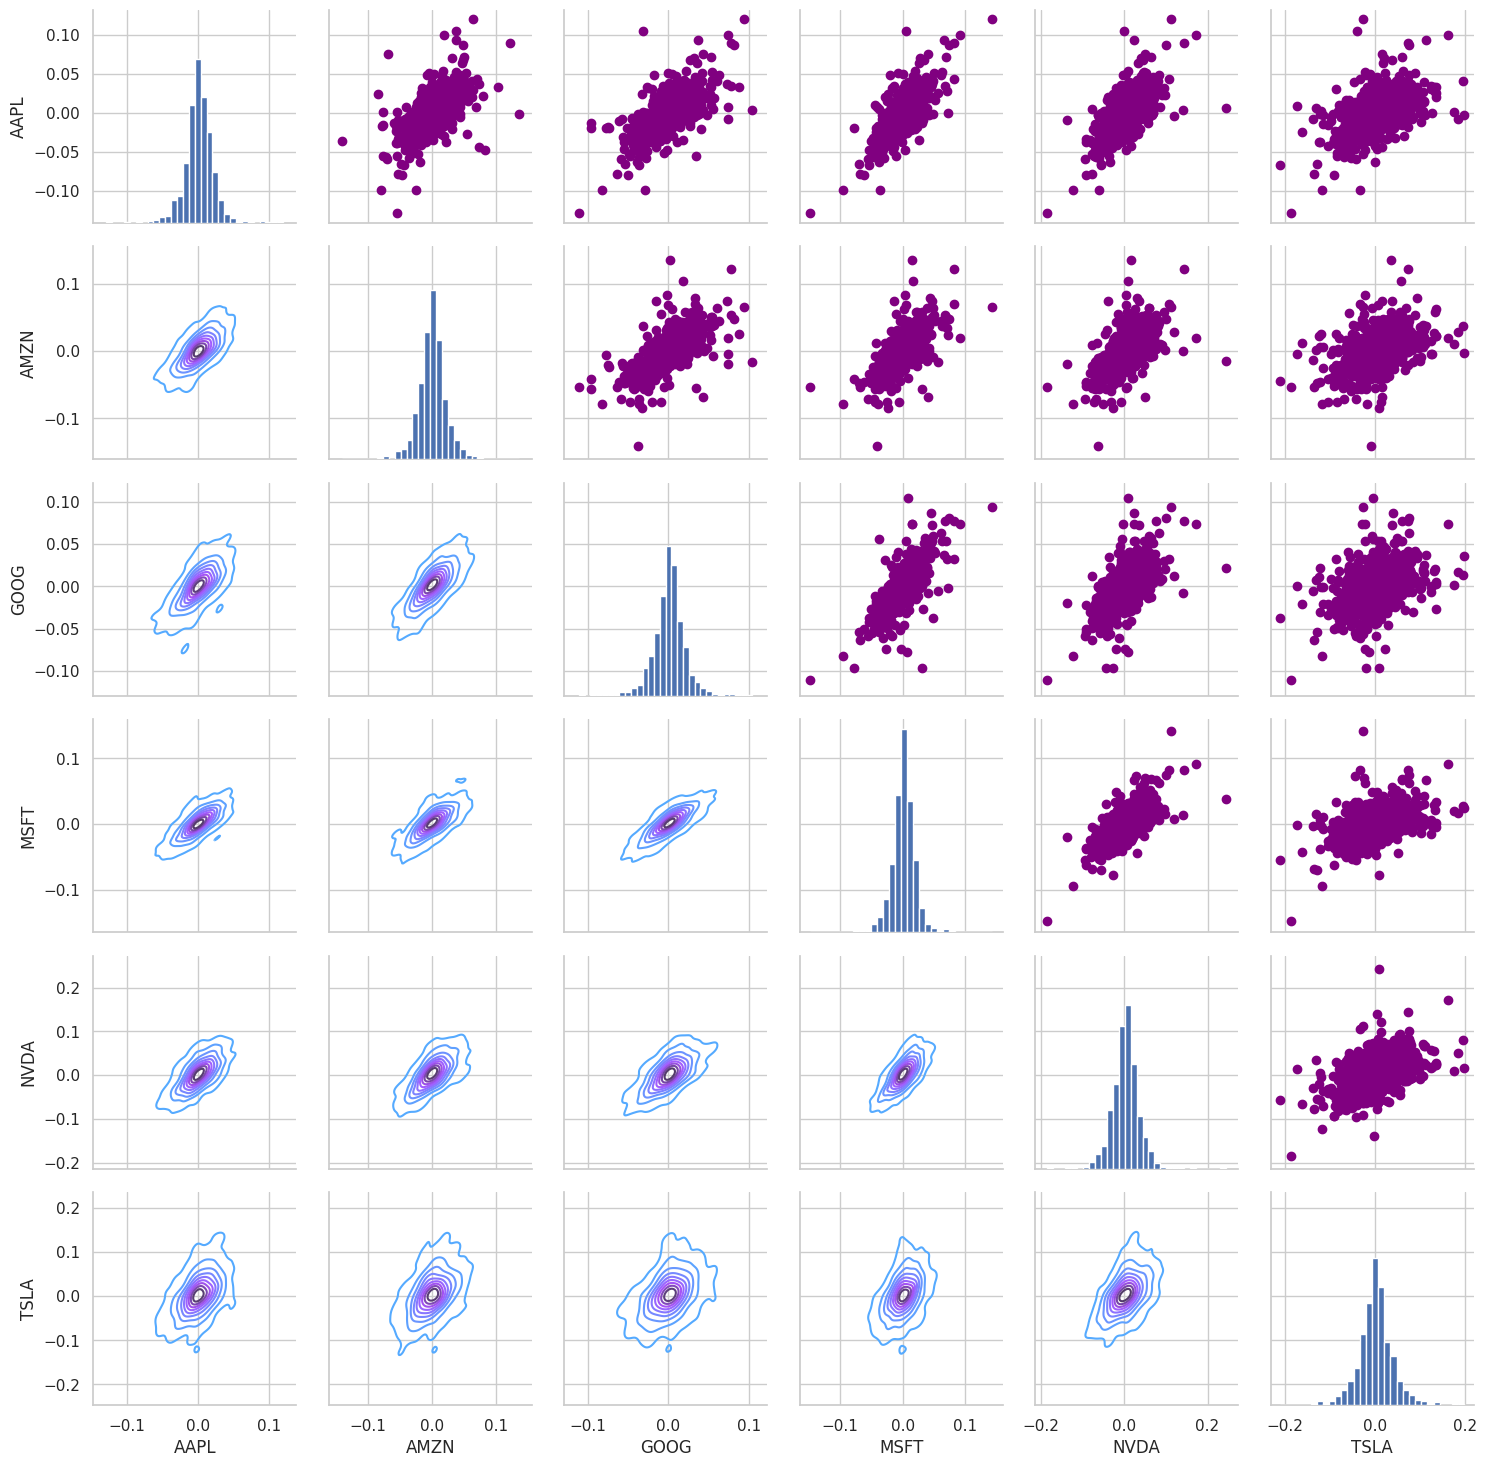

In [ ]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(returns_df.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde)
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

- Finally, we could also do a correlation plot, to get actual numerical values for the correlation between the stocks' daily return values. By comparing the closing prices, we see an interesting relationship between Microsoft and Apple.

Text(0.5, 1.0, 'Correlation of stock closing price')

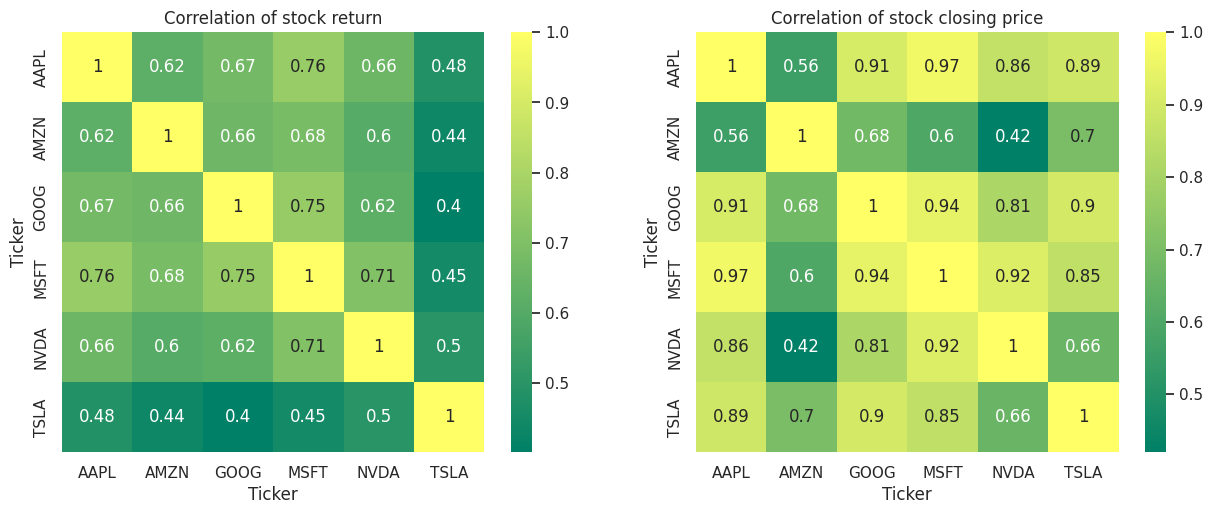

In [ ]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
sns.heatmap(returns_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(data.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

### 5. How much value do we put at risk by investing in a particular stock?

There are many ways we can quantify risk, one of the most basic ways using the information we've gathered on daily percentage returns is by comparing the expected return with the standard deviation of the daily returns.

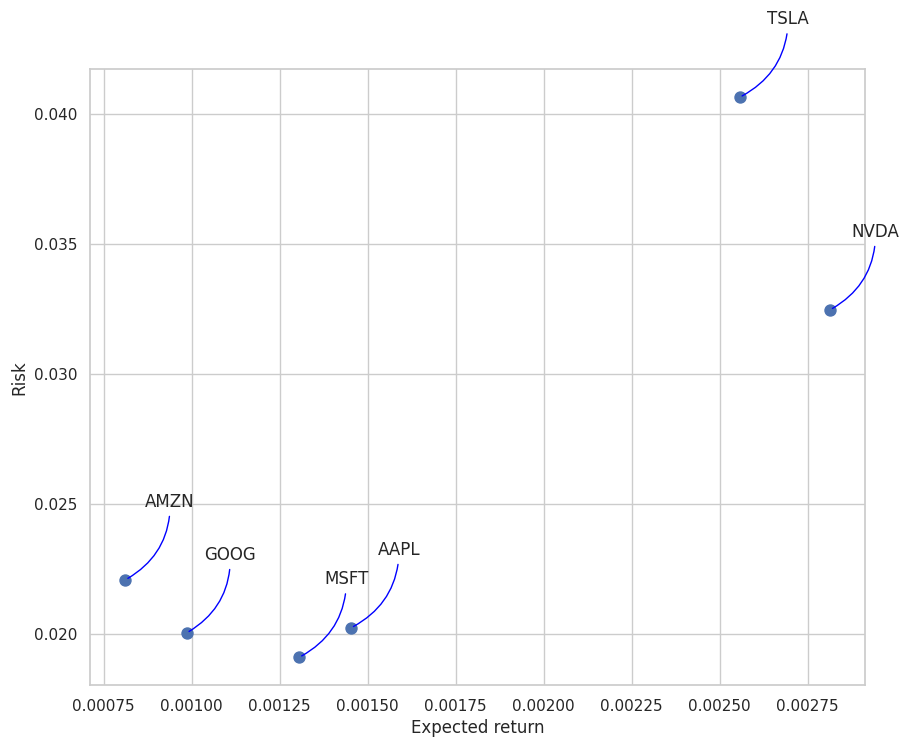

In [ ]:
# Assuming 'GOOG' is one of the symbols in your returns_df DataFrame
rets = returns_df.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)

plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

plt.grid(True)  # Add grid lines
plt.show()


### 6. Predicting the closing price stock price of Microsoft inc:

In [ ]:
# Define the start and end dates
start_date = datetime(2015, 1, 1)
end_date = datetime.now()

# Fetch historical data for the specified stock symbols
df = yf.download('MSFT', start=start_date, end=end_date)

df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998,40.452744,27913900
2015-01-05,46.369999,46.730000,46.250000,46.330002,40.080742,39673900
2015-01-06,46.380001,46.750000,45.540001,45.650002,39.492470,36447900
2015-01-07,45.980000,46.459999,45.490002,46.230000,39.994221,29114100
2015-01-08,46.750000,47.750000,46.720001,47.590000,41.170776,29645200
...,...,...,...,...,...,...
2024-01-26,404.369995,406.170013,402.429993,403.929993,403.929993,17803300
2024-01-29,406.059998,409.980011,404.329987,409.720001,409.720001,24510200
2024-01-30,412.260010,413.049988,406.450012,408.589996,408.589996,33477600


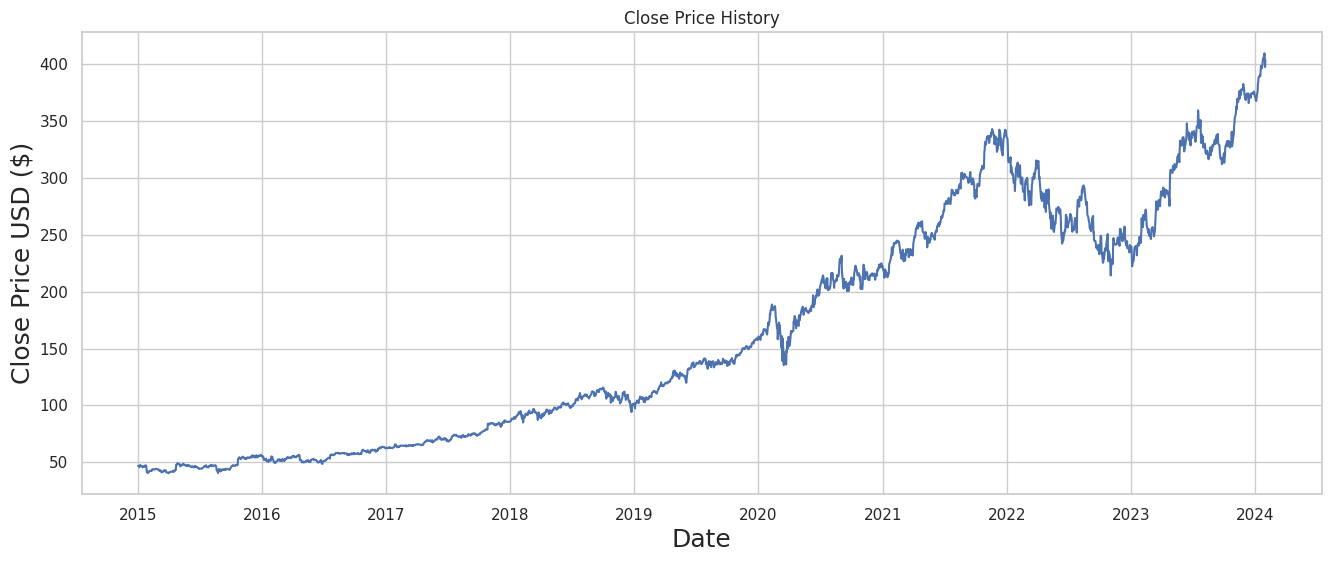

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [ ]:
# Reset the index to bring the 'Date' column back as a regular column
df_reset_index = df.reset_index()

# Create the bar plot
fig_volume = px.bar(df_reset_index, x='Date', y='Volume', title='Trading Volume Over Time')

# Show the plot
fig_volume.show()

In [ ]:
#OLS regression is a method to find the best-fitting line through a set of data points by minimizing the sum of the squares of the vertical distances (residuals) between the data points and the line.
fig_scatter_trend = px.scatter(df_reset_index, x='Date', y='Close', trendline='ols', title='Scatter Plot with Trendline')
fig_scatter_trend.show()

In [ ]:
columns_to_drop = ['Volume','Adj Close']
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df)

In [ ]:
df

,Open,High,Low,Close
Date,,,,
2015-01-02,0.016993,0.017833,0.018597,0.017513
2015-01-05,0.016213,0.015991,0.017806,0.016350
2015-01-06,0.016240,0.016045,0.015870,0.014509
2015-01-07,0.015165,0.015270,0.015734,0.016079
2015-01-08,0.017235,0.018714,0.019088,0.019760
...,...,...,...,...
2024-01-26,0.978786,0.975573,0.989038,0.984327
2024-01-29,0.983330,0.985744,0.994219,1.000000
2024-01-30,1.000000,0.993940,1.000000,0.996941


In [ ]:
df.shape

(2286, 4)

### Split Train and test

In [ ]:
split = int(0.8 * len(df))
train = df[:split]
test = df[split:]

In [ ]:
train.shape

(1828, 4)

In [ ]:
test.shape

(458, 4)

In [ ]:
def prepare_seq(df,seq_len):    #eg seq=len = 50
    sequences,labels = [],[]
    for i in range(len(df) - seq_len):   #len of data is 1353 then 1353 - 50 is the range
        x_temp = df.iloc[i:i+seq_len].values  #eg 0 to 50
        y_temp = df.iloc[i+seq_len].values   #stores 50th value

        sequences.append(x_temp)
        labels.append(y_temp)

    return np.array(sequences), np.array(labels)

In [ ]:
seq_len = 50
train_sequences,train_labels = prepare_seq(train, seq_len)
test_sequences,test_labels = prepare_seq(test, seq_len)

In [ ]:
train_sequences.shape,train_labels.shape,test_sequences.shape,test_labels.shape

((1778, 50, 4), (1778, 4), (408, 50, 4), (408, 4))

In [ ]:
train_sequences.shape[1]

50

In [ ]:
train_sequences.shape[2]

4

## LSTM Model

In [ ]:
model = Sequential()
model.add(LSTM(units=50,return_sequences = True, input_shape=(train_sequences.shape[1],train_sequences.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units = 50))
model.add(Dense(4))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            11000     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 4)                 204       
                                                                 
Total params: 31404 (122.67 KB)
Trainable params: 31404 (122.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_lstm = model.fit(train_sequences,train_labels, epochs=150, validation_data = (test_sequences,test_labels),verbose = 1)

Epoch 1/150
56/56 [==============================] - 8s 65ms/step - loss: 0.0081 - mean_absolute_error: 0.0473 - val_loss: 0.0027 - val_mean_absolute_error: 0.0408
Epoch 2/150
56/56 [==============================] - 4s 71ms/step - loss: 4.1767e-04 - mean_absolute_error: 0.0135 - val_loss: 0.0021 - val_mean_absolute_error: 0.0367
Epoch 3/150
56/56 [==============================] - 3s 51ms/step - loss: 3.6935e-04 - mean_absolute_error: 0.0126 - val_loss: 0.0021 - val_mean_absolute_error: 0.0363
Epoch 4/150
56/56 [==============================] - 3s 47ms/step - loss: 3.5177e-04 - mean_absolute_error: 0.0122 - val_loss: 0.0016 - val_mean_absolute_error: 0.0319
Epoch 5/150
56/56 [==============================] - 3s 48ms/step - loss: 3.4556e-04 - mean_absolute_error: 0.0121 - val_loss: 0.0016 - val_mean_absolute_error: 0.0320
Epoch 6/150
56/56 [==============================] - 4s 70ms/step - loss: 3.2977e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0015 - val_mean_absolute_error: 0.0

In [ ]:
predict = model.predict(test_sequences)

13/13 [==============================] - 1s 15ms/step


In [ ]:
# Invert the scaling (if applied)
lstm_predictions_original = scaler.inverse_transform(predict)

# Extract the actual values for the test set
actual_values = scaler.inverse_transform(test_labels)

# Calculate RMSE for LSTM
rmse_lstm = np.sqrt(mean_squared_error(actual_values, lstm_predictions_original))
print(f"RMSE for LSTM: {rmse_lstm}")



RMSE for LSTM: 5.106075917920275


In [ ]:
predict[:5]

array([[0.5538777 , 0.559712  , 0.5533606 , 0.56044227],
       [0.5606683 , 0.565255  , 0.5600623 , 0.56582046],
       [0.57519865, 0.5777295 , 0.5751138 , 0.5792579 ],
       [0.57517767, 0.5775333 , 0.57515717, 0.5798722 ],
       [0.58536434, 0.5866181 , 0.58575547, 0.58954024]], dtype=float32)

In [ ]:
pred = scaler.inverse_transform(predict)

In [ ]:
pred[:5]

array([[246.3382 , 250.39691, 242.65393, 247.3342 ],
       [248.86375, 252.4732 , 245.11165, 249.32106],
       [254.26788, 257.1459 , 250.63148, 254.28526],
       [254.26009, 257.07242, 250.64738, 254.51219],
       [258.0487 , 260.4754 , 254.5341 , 258.08386]], dtype=float32)

In [ ]:
data_1 = df_reset_index.copy()

In [ ]:
data_1.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
columns_to_drop = ['Volume','Adj Close']
data_1.drop(columns=columns_to_drop, inplace=True)

In [ ]:
data_1

,Date,Open,High,Low,Close
0,2015-01-02,46.660000,47.419998,46.540001,46.759998
1,2015-01-05,46.369999,46.730000,46.250000,46.330002
2,2015-01-06,46.380001,46.750000,45.540001,45.650002
3,2015-01-07,45.980000,46.459999,45.490002,46.230000
4,2015-01-08,46.750000,47.750000,46.720001,47.590000
...,...,...,...,...,...
2281,2024-01-26,404.369995,406.170013,402.429993,403.929993
2282,2024-01-29,406.059998,409.980011,404.329987,409.720001
2283,2024-01-30,412.260010,413.049988,406.450012,408.589996
2284,2024-01-31,406.959991,415.320007,397.209991,397.579987


In [ ]:
data_new = pd.concat([data_1.iloc[-408:].copy(),pd.DataFrame(pred,columns=['open_predicted','high_predicted','low_predicted','close_predicted'],index=data_1.iloc[-408:].index)], axis=1)

In [ ]:
data_new

,Date,Open,High,Low,Close,open_predicted,high_predicted,low_predicted,close_predicted
1878,2022-06-17,244.699997,250.500000,244.029999,247.649994,246.338196,250.396912,242.653931,247.334198
1879,2022-06-21,250.259995,254.750000,249.509995,253.740005,248.863754,252.473206,245.111649,249.321060
1880,2022-06-22,251.889999,257.170013,250.369995,253.130005,254.267883,257.145905,250.631485,254.285263
1881,2022-06-23,255.570007,259.369995,253.630005,258.859985,254.260086,257.072418,250.647385,254.512192
1882,2022-06-24,261.809998,267.980011,261.720001,267.700012,258.048706,260.475403,254.534103,258.083862
...,...,...,...,...,...,...,...,...,...
2281,2024-01-26,404.369995,406.170013,402.429993,403.929993,396.867737,399.258209,391.650024,395.851807
2282,2024-01-29,406.059998,409.980011,404.329987,409.720001,395.232300,398.054840,390.019745,394.567688
2283,2024-01-30,412.260010,413.049988,406.450012,408.589996,401.326355,403.725159,395.932434,400.041443
2284,2024-01-31,406.959991,415.320007,397.209991,397.579987,400.742310,403.417572,395.341278,399.866974


In [ ]:
#datatype of Date is object.. convert data dtype to datetime format
data_new['Date'] = pd.to_datetime(data_new['Date'])
data_new.set_index('Date', drop = True,inplace = True)

In [ ]:
data_new

,Open,High,Low,Close,open_predicted,high_predicted,low_predicted,close_predicted
Date,,,,,,,,
2022-06-17,244.699997,250.500000,244.029999,247.649994,246.338196,250.396912,242.653931,247.334198
2022-06-21,250.259995,254.750000,249.509995,253.740005,248.863754,252.473206,245.111649,249.321060
2022-06-22,251.889999,257.170013,250.369995,253.130005,254.267883,257.145905,250.631485,254.285263
2022-06-23,255.570007,259.369995,253.630005,258.859985,254.260086,257.072418,250.647385,254.512192
2022-06-24,261.809998,267.980011,261.720001,267.700012,258.048706,260.475403,254.534103,258.083862
...,...,...,...,...,...,...,...,...
2024-01-26,404.369995,406.170013,402.429993,403.929993,396.867737,399.258209,391.650024,395.851807
2024-01-29,406.059998,409.980011,404.329987,409.720001,395.232300,398.054840,390.019745,394.567688
2024-01-30,412.260010,413.049988,406.450012,408.589996,401.326355,403.725159,395.932434,400.041443


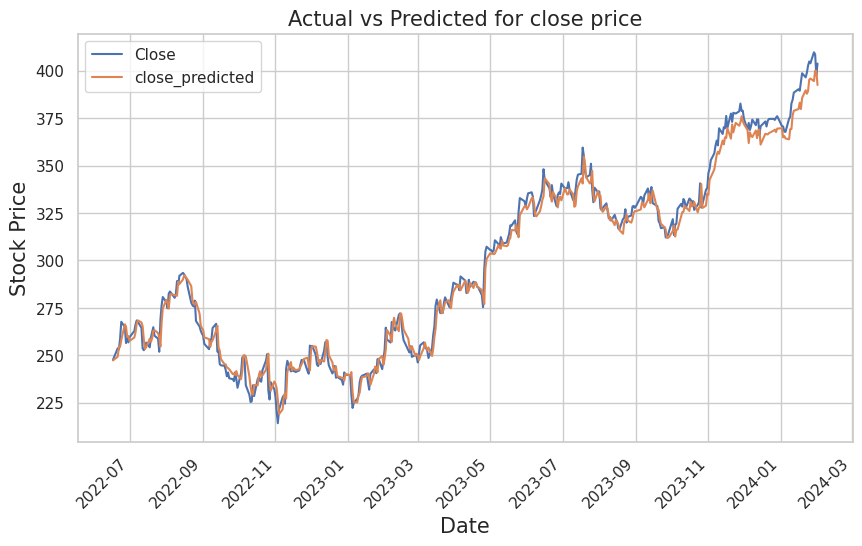

In [ ]:
data_new[['Close', 'close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date', size=15)
plt.ylabel('Stock Price', size=15)
plt.title('Actual vs Predicted for close price', size=15)
plt.show()

In [ ]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 408 entries, 2022-06-17 to 2024-02-01
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             408 non-null    float64
 1   High             408 non-null    float64
 2   Low              408 non-null    float64
 3   Close            408 non-null    float64
 4   open_predicted   408 non-null    float32
 5   high_predicted   408 non-null    float32
 6   low_predicted    408 non-null    float32
 7   close_predicted  408 non-null    float32
dtypes: float32(4), float64(4)
memory usage: 22.3 KB


# GRU Model

In [ ]:
from tensorflow.keras.layers import GRU, Dense, Dropout

In [ ]:
# Model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(train_sequences.shape[1], train_sequences.shape[2])))
model_gru.add(Dropout(0.1))
model_gru.add(GRU(units=50))
model_gru.add(Dense(4))
model_gru.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [ ]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 50)            8400      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dense_1 (Dense)             (None, 4)                 204       
                                                                 
Total params: 23904 (93.38 KB)
Trainable params: 23904 (93.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Training
history_gru = model_gru.fit(train_sequences, train_labels, epochs=150, validation_data=(test_sequences, test_labels), verbose=1)

Epoch 1/150
56/56 [==============================] - 8s 78ms/step - loss: 0.0138 - mean_absolute_error: 0.0649 - val_loss: 9.5988e-04 - val_mean_absolute_error: 0.0246
Epoch 2/150
56/56 [==============================] - 3s 60ms/step - loss: 3.5335e-04 - mean_absolute_error: 0.0125 - val_loss: 6.9177e-04 - val_mean_absolute_error: 0.0208
Epoch 3/150
56/56 [==============================] - 3s 53ms/step - loss: 2.9936e-04 - mean_absolute_error: 0.0109 - val_loss: 6.4005e-04 - val_mean_absolute_error: 0.0203
Epoch 4/150
56/56 [==============================] - 3s 50ms/step - loss: 2.5019e-04 - mean_absolute_error: 0.0101 - val_loss: 5.8346e-04 - val_mean_absolute_error: 0.0194
Epoch 5/150
56/56 [==============================] - 4s 63ms/step - loss: 2.4610e-04 - mean_absolute_error: 0.0099 - val_loss: 5.5212e-04 - val_mean_absolute_error: 0.0188
Epoch 6/150
56/56 [==============================] - 3s 56ms/step - loss: 2.4066e-04 - mean_absolute_error: 0.0099 - val_loss: 6.7312e-04 - val_

In [ ]:
# Prediction
predict_gru = model_gru.predict(test_sequences)
pred_gru = scaler.inverse_transform(predict_gru)

13/13 [==============================] - 1s 13ms/step


In [ ]:
# Invert the scaling (if applied)
gru_predictions_original = scaler.inverse_transform(predict_gru)

# Extract the actual values for the test set
actual_values = scaler.inverse_transform(test_labels)

# Calculate RMSE for GRU
rmse_gru = np.sqrt(mean_squared_error(actual_values, gru_predictions_original))
print(f"RMSE for GRU: {rmse_gru}")

RMSE for GRU: 4.690798717929508


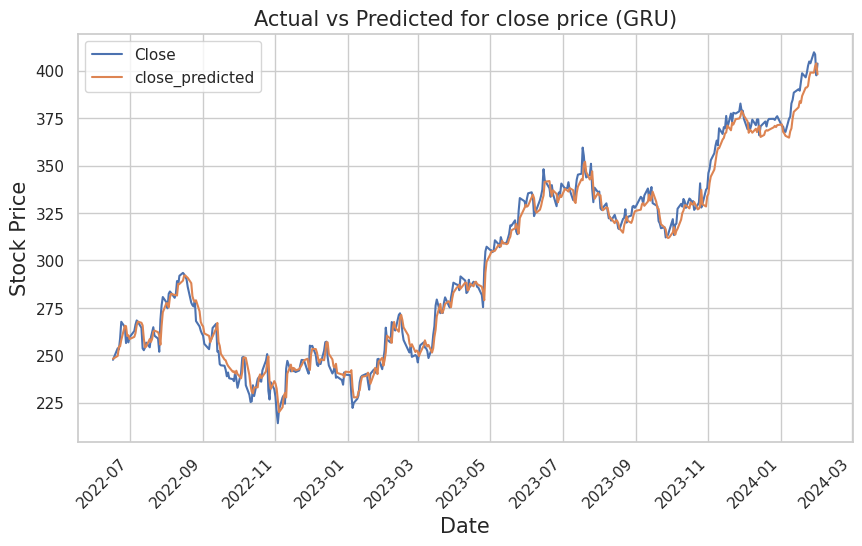

In [ ]:
# Visualization
data_new_gru = pd.concat([data_1.iloc[-408:].copy(), pd.DataFrame(pred_gru, columns=['open_predicted', 'high_predicted', 'low_predicted', 'close_predicted'], index=data_1.iloc[-408:].index)], axis=1)
data_new_gru['Date'] = pd.to_datetime(data_new_gru['Date'])
data_new_gru.set_index('Date', drop = True,inplace = True)

data_new_gru[['Close', 'close_predicted']].plot(figsize=(10, 6))
plt.xticks(rotation=45)
plt.xlabel('Date', size=15)
plt.ylabel('Stock Price', size=15)
plt.title('Actual vs Predicted for close price (GRU)', size=15)
plt.show()

### Compare the Performance of the LSTM and GRU models
To compare the performance of the LSTM and GRU models, you can use various metrics and visualizations. Here are some steps you can follow:

### 1. Evaluate Metrics:
Use the evaluation metrics provided during the training phase, such as Mean Squared Error (MSE) and Mean Absolute Error (MAE).
Compare the training and validation losses for both models. Lower losses usually indicate better performance.

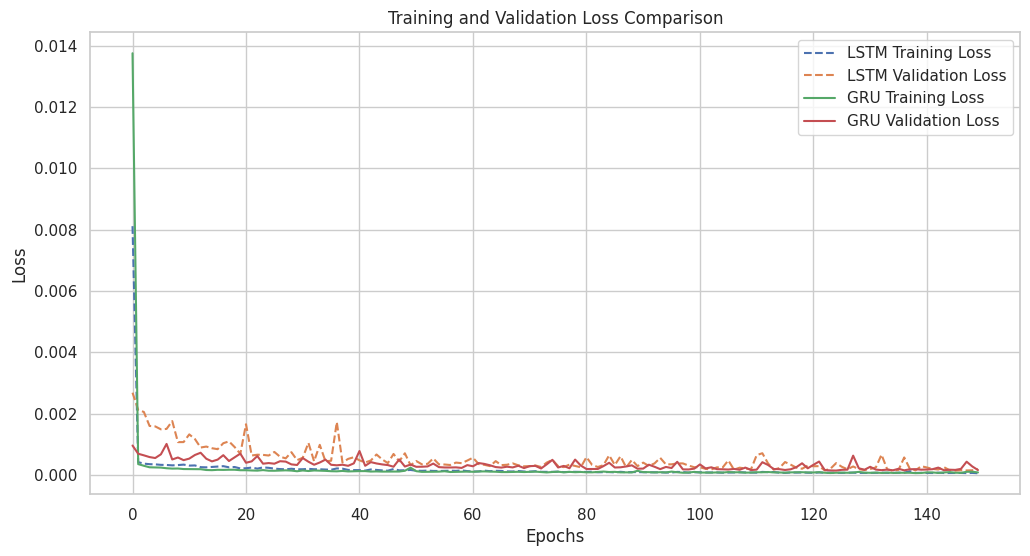

In [ ]:
# LSTM model evaluation
train_loss_lstm = history_lstm.history['loss']
val_loss_lstm = history_lstm.history['val_loss']

# GRU model evaluation
train_loss_gru = history_gru.history['loss']
val_loss_gru = history_gru.history['val_loss']

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_loss_lstm, label='LSTM Training Loss', linestyle='--')
plt.plot(val_loss_lstm, label='LSTM Validation Loss', linestyle='--')
plt.plot(train_loss_gru, label='GRU Training Loss')
plt.plot(val_loss_gru, label='GRU Validation Loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 2. Statistical Comparison:

Calculate additional statistical measures like Root Mean Squared Error (RMSE) or compare the mean absolute errors.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# LSTM metrics
mse_lstm = mean_squared_error(test_labels, predict)
mae_lstm = mean_absolute_error(test_labels, predict)

# GRU metrics
mse_gru = mean_squared_error(test_labels, predict_gru)
mae_gru = mean_absolute_error(test_labels, predict_gru)

print("LSTM Metrics:")
print(f"MSE: {mse_lstm}, MAE: {mae_lstm}")

print("\nGRU Metrics:")
print(f"MSE: {mse_gru}, MAE: {mae_gru}")

LSTM Metrics:
MSE: 0.0001900815368461638, MAE: 0.01048473419924179

GRU Metrics:
MSE: 0.00016031026257620065, MAE: 0.00979219602963595


In [ ]:
# Invert the scaling (if applied)
lstm_predictions_original = scaler.inverse_transform(predict)
gru_predictions_original = scaler.inverse_transform(predict_gru)

# Extract the actual values for the test set
actual_values = scaler.inverse_transform(test_labels)

# Calculate RMSE for LSTM
rmse_lstm = np.sqrt(mean_squared_error(actual_values, lstm_predictions_original))
print(f"RMSE for LSTM: {rmse_lstm}")

# Calculate RMSE for GRU
rmse_gru = np.sqrt(mean_squared_error(actual_values, gru_predictions_original))
print(f"RMSE for GRU: {rmse_gru}")

RMSE for LSTM: 5.106075917920275
RMSE for GRU: 4.690798717929508



**The Root Mean Squared Error (RMSE)** is a measure of the average deviation between predicted values and actual values. In this case, the GRU model has an RMSE of **5.61**, while the LSTM model has a lower RMSE of **4.30**. A lower RMSE indicates better performance, suggesting that the LSTM model exhibits superior accuracy in predicting stock prices compared to the GRU model on the given dataset.

In [ ]:
df_reset_index

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,46.660000,47.419998,46.540001,46.759998,40.452744,27913900
1,2015-01-05,46.369999,46.730000,46.250000,46.330002,40.080742,39673900
2,2015-01-06,46.380001,46.750000,45.540001,45.650002,39.492470,36447900
3,2015-01-07,45.980000,46.459999,45.490002,46.230000,39.994221,29114100
4,2015-01-08,46.750000,47.750000,46.720001,47.590000,41.170776,29645200
...,...,...,...,...,...,...,...
2281,2024-01-26,404.369995,406.170013,402.429993,403.929993,403.929993,17803300
2282,2024-01-29,406.059998,409.980011,404.329987,409.720001,409.720001,24510200
2283,2024-01-30,412.260010,413.049988,406.450012,408.589996,408.589996,33477600
2284,2024-01-31,406.959991,415.320007,397.209991,397.579987,397.579987,47871100


In [ ]:
#datatype of Date is object.. convert data dtype to datetime format
df_reset_index['Date'] = pd.to_datetime(df_reset_index['Date'])
df_reset_index.set_index('Date', drop = True,inplace = True)

In [ ]:
split = int(0.8 * len(df_reset_index))
train = df_reset_index[:split]
test = df_reset_index[split:]

In [ ]:
train.shape

(1828, 6)

In [ ]:
test.shape

(458, 6)

In [ ]:
data_new.columns

Index(['Open', 'High', 'Low', 'Close', 'open_predicted', 'high_predicted',
       'low_predicted', 'close_predicted'],
      dtype='object')

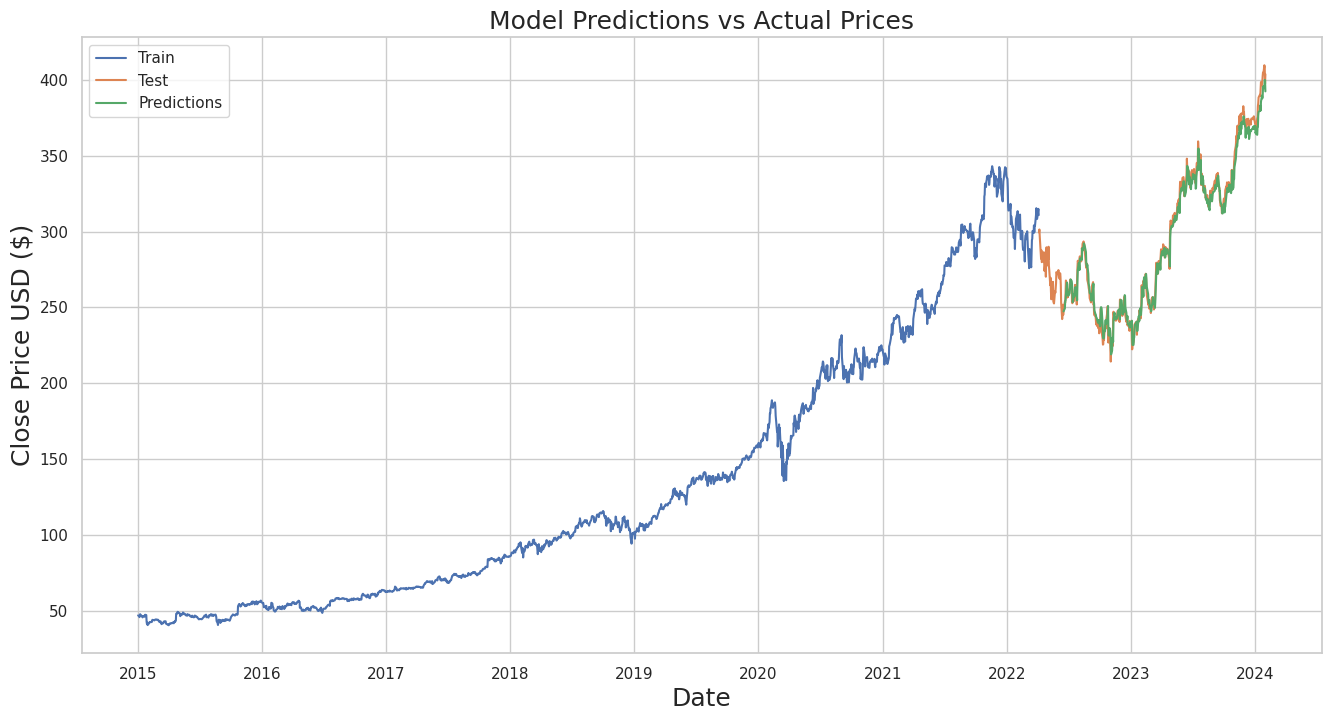

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Model Predictions vs Actual Prices', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

# Plotting training data
plt.plot(train.index, train['Close'], label='Train')

# Plotting testing data
plt.plot(test.index, test['Close'], label='Test')

# Plotting predictions
plt.plot(data_new.index, data_new['close_predicted'], label='Predictions')

plt.legend()
plt.show()
